In [ ]:
!pip3 install tensorflow_text

     |████████████████████████████████| 4.9 MB 7.8 MB/s 


IMPORTING PACKAGES


In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_text as tf_text
import re
import string
import random
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import re
import string
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer


BELOW IS A HELPER FUNCTION WHICH GENERATES RANDOM COLOURS,THAT ARE USED TO GIVE DIFFERENT COLOURS TO THE PLOTS

In [ ]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

READ DATASET

In [ ]:
train = pd.read_csv('/content/Corona_NLP_train.csv', encoding = "ISO-8859-1")
test =pd.read_csv('/content/Corona_NLP_test.csv')

BASIC EDA

In [ ]:
#get summary of the training dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
#let's look at the first row of the training data
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
#summary of the testing dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [ ]:
#first row of the testing dataset
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
#combine the training and testing data 
frames = [train, test]
data = pd.concat(frames)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44955 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


In [ ]:
#check for missing data 
missing = data['Location'].isnull()


print(data[missing])

      UserName  ...           Sentiment
3         3802  ...            Positive
4         3803  ...  Extremely Negative
14        3813  ...            Positive
22        3821  ...  Extremely Positive
23        3822  ...  Extremely Positive
...        ...  ...                 ...
3767      3768  ...            Positive
3777      3778  ...             Neutral
3778      3779  ...             Neutral
3779      3780  ...            Positive
3796      3797  ...  Extremely Negative

[9424 rows x 6 columns]


In [ ]:
#replace missing data 
data['Location'] = data['Location'].replace(np.nan, "Unknown")
#test['Location'] = test['Location'].replace(np.nan, "Unknown")

In [ ]:
#check again for missing data
data[data['Location'].isnull()]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment


In [ ]:
#check for duplicates in the data
dups = data.duplicated()
data[dups]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment


In [ ]:
# Check for Locations distribution
loc_dist = data['Location'].unique()
print(len(loc_dist))

13137


In [ ]:
#summary of the whole data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44955 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       44955 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


Sentiment distribution

In [ ]:
#plot total negative vs total positive
pos  = len(data[data['Sentiment'] == 'Positive'])
ext_pos = len(data[data['Sentiment'] == 'Extremely Positive'])

neut =len(data[data['Sentiment'] == 'Neutral'])

neg = len(data[data['Sentiment'] == 'Negative'])
ext_neg = len(data[data['Sentiment'] == 'Extremely Negative'])

total_positive = pos + ext_pos
total_negative = neg + ext_neg

tt_label = ["Total Positive", "Neutral", "Total Negative"]
tt = [total_positive, neut, total_negative]

visualization

In [ ]:
temp = data.groupby('Sentiment').count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Sentiment,OriginalTweet
4,Positive,12369
2,Negative,10958
3,Neutral,8332
1,Extremely Positive,7223
0,Extremely Negative,6073


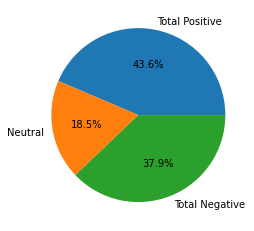

In [ ]:
#plot
plt.pie(tt, labels=tt_label, autopct='%1.1f%%')
plt.show()



The charts above gives the summary of the whole data categorized into 3 classes.

The positive column comprises of the Positive and Extremely positive sentiments which acounts for 43.6% of the total data.

The Negative column, with 37.9%, represents the total of the Negative and Extremely Negative sentiments, while the Neutral sentiments representing 18.5% of the total data

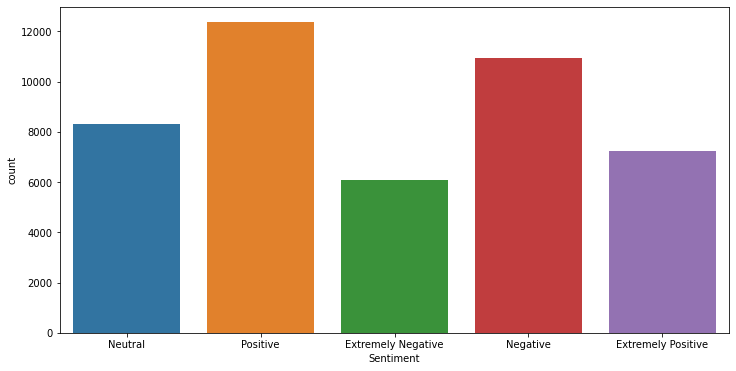

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment',data=data)

A funnel-chart for better visualization

In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp.Sentiment,
    values = temp.OriginalTweet,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()



The plots above shows that Positive sentiments has the highest count at 27.5%, closely followed by the Negative sentiments data with 24.4% of the whole data. Neutral opininions occupy the center with about 18.5% of the records. Extremely Positive and Extremely Negative sentiments have values of 16.1% and 13.5% respectively.


In [ ]:
sentiment_count = data['Sentiment'].value_counts()
sentiment_count

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

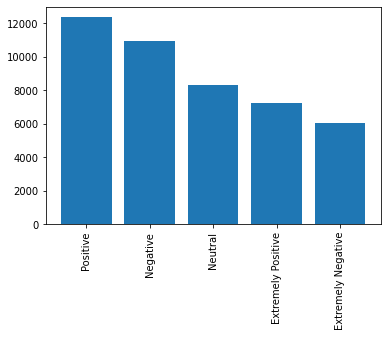

In [ ]:
#plot
plt.bar(sentiment_count.index,sentiment_count)
plt.xticks(rotation=90)
plt.show()

In [ ]:
#most common words on our targetted original tweet
data['temp_list'] = data['OriginalTweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in data['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,44192
1,to,40961
2,and,25414
3,of,23270
4,a,19641
5,in,19354
6,for,14586
7,#coronavirus,13245
8,is,12829
9,are,11852


In [ ]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in OriginalTweet ', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
#time series - start of date and end date - line plot frequency of positive and negative
day_total = data['TweetAt'].unique()
print(day_total)

['16-03-2020' '17-03-2020' '18-03-2020' '19-03-2020' '20-03-2020'
 '21-03-2020' '22-03-2020' '23-03-2020' '24-03-2020' '25-03-2020'
 '26-03-2020' '27-03-2020' '28-03-2020' '29-03-2020' '30-03-2020'
 '31-03-2020' '01-04-2020' '02-04-2020' '03-04-2020' '04-04-2020'
 '05-04-2020' '06-04-2020' '07-04-2020' '08-04-2020' '09-04-2020'
 '10-04-2020' '11-04-2020' '12-04-2020' '13-04-2020' '14-04-2020'
 '02-03-2020' '03-03-2020' '04-03-2020' '05-03-2020' '06-03-2020'
 '07-03-2020' '08-03-2020' '09-03-2020' '10-03-2020' '11-03-2020'
 '12-03-2020' '13-03-2020' '14-03-2020' '15-03-2020']


Modelling




Logistic Regresson

In [ ]:
#vectorizer:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['OriginalTweet'])
test_matrix = vectorizer.transform(test['OriginalTweet'])

In [ ]:
X_train1 = train_matrix
X_test1 = test_matrix
#y_train = train['sentiment']
#y_test = test['sentiment']

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

lab = train['Sentiment']
y_train1 = le.fit_transform(lab)
y_test1 = le.fit_transform(test['Sentiment'])



In [ ]:
#The model
lr = LogisticRegression(max_iter=10000)

In [ ]:
#Training the model
lr.fit(X_train1,y_train1)

LogisticRegression(max_iter=10000)

In [ ]:
#Make predictions
predictions1 = lr.predict(X_test1)

In [ ]:
print(predictions1[:10])

[3 4 4 2 3 3 4 2 0 4]


In [ ]:
#Show the results of the predictions
lab_names = test['Sentiment'].unique()
lab_names[predictions1[:10]]

array(['Negative', 'Neutral', 'Neutral', 'Extremely Positive', 'Negative',
       'Negative', 'Neutral', 'Extremely Positive', 'Extremely Negative',
       'Neutral'], dtype=object)

In [ ]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test1)
confusion_matrix(predictions1,y_test1)

array([[331,   5, 134,   7,  23],
       [  6, 367,  25,   7, 110],
       [218,  20, 584,  86, 127],
       [ 13,   7, 122, 443,  89],
       [ 24, 200, 176,  76, 598]])

In [ ]:
print(classification_report(predictions1,y_test1))

              precision    recall  f1-score   support

           0       0.56      0.66      0.61       500
           1       0.61      0.71      0.66       515
           2       0.56      0.56      0.56      1035
           3       0.72      0.66      0.69       674
           4       0.63      0.56      0.59      1074

    accuracy                           0.61      3798
   macro avg       0.62      0.63      0.62      3798
weighted avg       0.62      0.61      0.61      3798





LSTM


In [ ]:
#Get Text data from the Tweet Column
corpus = data['OriginalTweet']
corpus

0       @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1       advice Talk to your neighbours family to excha...
2       Coronavirus Australia: Woolworths to give elde...
3       My food stock is not the only one which is emp...
4       Me, ready to go at supermarket during the #COV...
                              ...                        
3793    Meanwhile In A Supermarket in Israel -- People...
3794    Did you panic buy a lot of non-perishable item...
3795    Asst Prof of Economics @cconces was on @NBCPhi...
3796    Gov need to do somethings instead of biar je r...
3797    I and @ForestandPaper members are committed to...
Name: OriginalTweet, Length: 44955, dtype: object

In [ ]:
#One-Hot Encoding of the labels
sentiment = pd.get_dummies(data['Sentiment'])
print(sentiment)

      Extremely Negative  Extremely Positive  Negative  Neutral  Positive
0                      0                   0         0        1         0
1                      0                   0         0        0         1
2                      0                   0         0        0         1
3                      0                   0         0        0         1
4                      1                   0         0        0         0
...                  ...                 ...       ...      ...       ...
3793                   0                   0         0        0         1
3794                   0                   0         1        0         0
3795                   0                   0         0        1         0
3796                   1                   0         0        0         0
3797                   0                   1         0        0         0

[44955 rows x 5 columns]


In [ ]:
print(len(corpus))
print(len(sentiment))

44955
44955


In [ ]:
# Create tokenizer to tokenize sentences
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize,word_tokenize
tokenizer= word_tokenize('text')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Words Tokenization
from nltk.tokenize import word_tokenize

all_words = []
for sent in corpus:
    tokenize_word = word_tokenize(sent)
    for word in tokenize_word:
        all_words.append(word)

In [ ]:
#Extract each word while ignoring duplicates
unique_words = set(all_words)
print(len(unique_words))

108246


In [ ]:
vocab_length = 101948
embedded_sentences = [one_hot(sent, vocab_length) for sent in corpus]
#print(embedded_sentences )

In [ ]:
#count number of words
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(corpus, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))

In [ ]:
#Fill the end of each sentence with '0' so that they all have same lenght
padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')
print(padded_sentences)

[[75465 97295 36843 ...     0     0     0]
 [17292 40849 17638 ...     0     0     0]
 [37771 28313 82784 ...     0     0     0]
 ...
 [43332 57026 61523 ...     0     0     0]
 [84249 43299 17638 ...     0     0     0]
 [64031 37588 75181 ...     0     0     0]]


In [ ]:
len(padded_sentences)

44955

In [ ]:
#divide the data into Training and Testing

X_train,X_test, y_train, y_test = train_test_split(padded_sentences, sentiment, train_size=0.9, random_state=42)

In [ ]:
#Build the Model 
model = Sequential()
model.add(Embedding(vocab_length, 20, input_length=length_long_sentence))
model.add(LSTM(20, return_sequences=True))
model.add(Dense(100, activation='relu'))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

In [ ]:
#compile model and show summary
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 235, 20)           2038960   
                                                                 
 lstm (LSTM)                 (None, 235, 20)           3280      
                                                                 
 dense (Dense)               (None, 235, 100)          2100      
                                                                 
 flatten (Flatten)           (None, 23500)             0         
                                                                 
 dense_1 (Dense)             (None, 5)                 117505    
                                                                 
Total params: 2,161,845
Trainable params: 2,161,845
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#train the model

model.fit(X_train, y_train, epochs=15, steps_per_epoch=200, verbose=1)

Epoch 1/15
200/200 [==============================] - 41s 193ms/step - loss: 1.3485 - acc: 0.4033
Epoch 2/15
200/200 [==============================] - 38s 191ms/step - loss: 0.7751 - acc: 0.7093
Epoch 3/15
200/200 [==============================] - 38s 190ms/step - loss: 0.4953 - acc: 0.8303
Epoch 4/15
200/200 [==============================] - 37s 187ms/step - loss: 0.4178 - acc: 0.8629
Epoch 5/15
200/200 [==============================] - 38s 188ms/step - loss: 0.2744 - acc: 0.9153
Epoch 6/15
200/200 [==============================] - 38s 192ms/step - loss: 0.1982 - acc: 0.9405
Epoch 7/15
200/200 [==============================] - 38s 188ms/step - loss: 0.1570 - acc: 0.9516
Epoch 8/15
200/200 [==============================] - 38s 188ms/step - loss: 0.1225 - acc: 0.9618
Epoch 9/15
200/200 [==============================] - 37s 186ms/step - loss: 0.1001 - acc: 0.9700
Epoch 10/15
200/200 [==============================] - 37s 184ms/step - loss: 0.0786 - acc: 0.9763
Epoch 11/15
200/200

In [ ]:
#Evaluate model performance
loss, accuracy = model.evaluate(padded_sentences, sentiment, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 95.135134


In [ ]:
#make predictions
predictions = model.predict(X_test)

In [ ]:
#Store Predictions result
pred_result = (np.argmax(predictions[:20], axis=1))



In [ ]:
#Show result of predictions
print(lab_names[pred_result])

['Positive' 'Neutral' 'Extremely Positive' 'Extremely Negative' 'Positive'
 'Extremely Positive' 'Neutral' 'Extremely Positive' 'Negative' 'Neutral'
 'Extremely Negative' 'Neutral' 'Positive' 'Extremely Positive' 'Neutral'
 'Extremely Positive' 'Positive' 'Extremely Positive' 'Neutral' 'Neutral']
